# Machine Learning HW5 - Hesam Korki

We need to first set the right environment for testing different approaches to the armed bandit problems


The general problem goal is to get an estimate of Qt(a):

   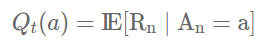
   
   
## Gereedy Method

The objective of this method is to only maximize the reward at each time step:

   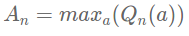

This means that we are only paying attention to the exploiting side of the problem, and exploring is not taking place. We could use a minute variable called epsilon for the method to explore a random action with that probability and exploit with the probability of (1 - eps), this is called eps-greedy. These two methods could efficiently be implemented with the same class:

In [65]:
#importing dependencies

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%config Completer.use_jedi = False

We define a class to represent the greedy method as an object with the following attributes:
- *k*: number of arms (int)
- *eps*: probability of random action (float)
- *iters*: number of steps (int)
- *rewards*: [default] is a set of random values normally distributed with mean = 0, could be set to a arbitrary array of size 'k'
- *decay*: [default] is set to NO, could be set to either EXP or INV

In [72]:
class GreedyBandit:
    
    def __init__(self, k, eps, iters, rewards='random', decay="NO"):
        
        self.k = k
        self.decay = decay
        if decay=="NO":
            self.eps = eps
        elif decay =="EXP":
            self.eps = math.exp(-1)
        else:
            self.eps = 1
            
        self.iters = iters
        
        #step count
        self.n = 0
        
        #step count for each arm
        self.k_n = np.zeros(k)
        
        #mean value
        self.mean = 0
        
        #reward history
        self.history = np.zeros(iters)
        
        #each arm reward history
        self.k_history = np.zeros(k)
        
        if type(rewards) == list or type(rewards).__module__ == np.__name__:
            #User-defined averages            
            self.rewards = np.array(rewards)
        elif rewards == 'random':
            #Draw means from probability distribution
            self.rewards = np.random.normal(0, 1, k)
    
    def calc_eps(self, t):
        if self.decay == "NO":
            return self.eps
        elif self.decay == "EXP":
            return math.exp(-(t+1))
        else:
            return 1/(t+1)
        
    def generate(self):
        
        p = np.random.rand()
        if self.eps == 0 and self.n == 0:
            a = np.random.choice(self.k)
        elif p < self.eps:
            # Random action
            a = np.random.choice(self.k)
        else:
            # Greedy action
            a = np.argmax(self.k_history)
            
        reward = np.random.normal(self.rewards[a], 1)
        
        self.n += 1
        self.k_n[a] += 1
        
        self.mean +=  (reward - self.mean)/self.n
        
        self.k_history[a] += (reward - self.k_history[a])/self.k_n[a]
        
        
    def go(self):
        
        for i in range(self.iters):
            self.eps = self.calc_eps(i)
            self.generate()
            self.history[i] = self.mean
    

We will compare results for the different amounts of epsilons, and assume that the bandit has 10 arms (k=10) and run 2000 steps for each epoch. 

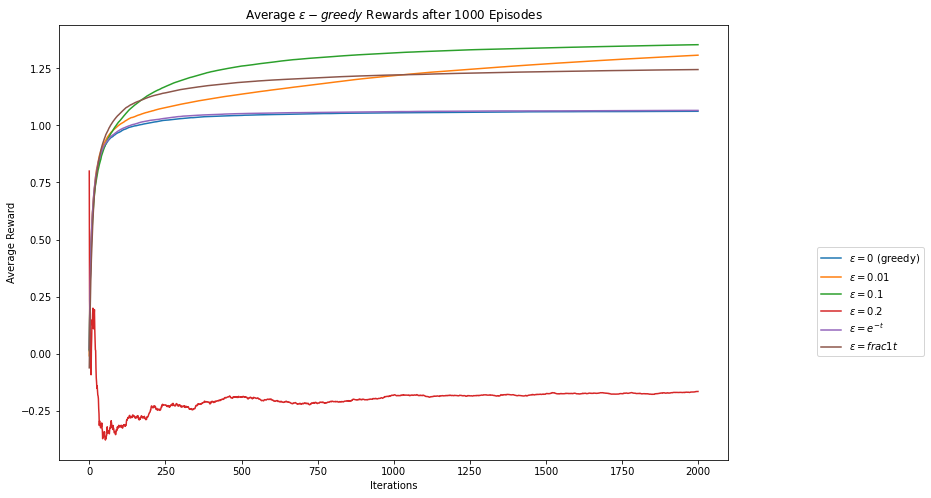

In [73]:
k = 10
iters = 2000

eps_0_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)
eps_2_rewards = np.zeros(iters)
eps_exp_rewards = np.zeros(iters)
eps_inv_rewards = np.zeros(iters)

eps_0_selection = np.zeros(k)
eps_01_selection = np.zeros(k)
eps_1_selection = np.zeros(k)
eps_2_selection = np.zeros(k)

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    eps_0 = GreedyBandit(k, 0, iters)
    eps_01 = GreedyBandit(k, 0.01, iters, eps_0.rewards.copy())
    eps_1 = GreedyBandit(k, 0.1, iters, eps_0.rewards.copy())
    eps_2 = GreedyBandit(k, 0.2, iters, eps_0.rewards.copy())
    eps_exp = GreedyBandit(k, 0, iters, eps_0.rewards.copy(), decay="EXP")
    eps_inv = GreedyBandit(k, 0, iters, eps_0.rewards.copy(), decay="INV")
    
    # Run experiments
    eps_0.go()
    eps_01.go()
    eps_1.go()
    eps_2.go()
    eps_exp.go()
    eps_inv.go()
    
    # Update long-term averages
    eps_0_rewards = eps_0_rewards + (
        eps_0.history - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (
        eps_01.history - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.history - eps_1_rewards) / (i + 1)
    eps_2_rewards = eps_2_rewards + (
        eps_1.history - eps_1_rewards) / (i + 1)
    
    eps_exp_rewards += (eps_exp.history - eps_exp_rewards)/(i+1)
    eps_inv_rewards += (eps_inv.history - eps_inv_rewards)/(i+1)
    
    # Average actions per episode
    eps_0_selection += (eps_0.k_n - eps_0_selection)/(i+1)
    eps_01_selection += (eps_01.k_n - eps_01_selection)/(i+1)
    eps_1_selection += (eps_1.k_n - eps_1_selection)/(i+1)
    eps_2_selection += (eps_2.k_n - eps_2_selection)/(i+1)
    
    
plt.figure(figsize=(12,8))
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_rewards, label="$\epsilon=0.01$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.plot(eps_2_rewards, label="$\epsilon=0.2$")
plt.plot(eps_exp_rewards, label="$\epsilon=e^{-t}$")
plt.plot(eps_inv_rewards, label="$\epsilon=frac{1}{t}$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) 
    + " Episodes")
plt.show()

As we expected the epsilon-greedy method achieves better results than the greedy method which only exploits. However, when the amount of epsilon exceedes a certain amount like 0.2 the average reward would be unstable and would not definitely converge. Another diagram that is worthed to plot is the percentage of choosing the efficient action through iterations.

In [64]:
print(max(eps_0_selection))
print(eps_1_selection)
print(eps_1.k_n)
print("k_history", eps_1.k_history)

447.1710000000002
[220.649 189.095 186.011 194.834 180.093 202.009 229.241 213.187 197.514
 187.367]
[ 239.  354.   23.   20.   22.   21.   19.   23. 1254.   25.]
k_history [ 1.72335482  2.7295386   0.59103039  0.47331062 -0.58932046  0.70822318
  0.21320727 -0.22548088  2.25302822 -1.10574295]


In [ ]:
opt